In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../dataset/housing.csv')
df.drop('ocean_proximity', axis=1, inplace=True)
df.drop('longitude', axis=1, inplace=True)
df.drop('latitude', axis=1, inplace=True)
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   housing_median_age  20640 non-null  float64
 1   total_rooms         20640 non-null  float64
 2   total_bedrooms      20433 non-null  float64
 3   population          20640 non-null  float64
 4   households          20640 non-null  float64
 5   median_income       20640 non-null  float64
 6   median_house_value  20640 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [4]:
df.shape

(20640, 7)

In [5]:
df.isnull().sum()

housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [6]:
from sklearn.neighbors import KNeighborsRegressor

def impute_knn(df):
    # seperate the dataset into numerical and categorical
    ldf = df.select_dtypes(include=[np.number])
    ldf_putaside = df.select_dtypes(exclude=[np.number])

    #define col with missing values
    col_missing = ldf.columns[ldf.isnull().any()].tolist()
    #define col without missing values
    col_no_missing = ldf.columns.difference(col_missing).values

    for col in col_missing:
        imp_test = ldf[ldf[col].isna()]
        imp_train = ldf.dropna()

        model = KNeighborsRegressor(n_neighbors=5)
        knr = model.fit(imp_train[col_no_missing], imp_train[col])
        ldf.loc[ldf[col].isnull(), col] = knr.predict(imp_test[col_no_missing])
    
    return pd.concat([ldf, ldf_putaside], axis=1)

In [7]:
df2 = impute_knn(df)
df2.isnull().sum()  

housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   housing_median_age  20640 non-null  float64
 1   total_rooms         20640 non-null  float64
 2   total_bedrooms      20640 non-null  float64
 3   population          20640 non-null  float64
 4   households          20640 non-null  float64
 5   median_income       20640 non-null  float64
 6   median_house_value  20640 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [9]:
y = df2['median_house_value'].values
df2 = df2[['total_rooms', 'total_bedrooms', 'housing_median_age', 'median_income', 'population', 'households']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_rooms         20640 non-null  float64
 1   total_bedrooms      20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   median_income       20640 non-null  float64
 4   population          20640 non-null  float64
 5   households          20640 non-null  float64
dtypes: float64(6)
memory usage: 967.6 KB


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df2, y, test_size=0.3, random_state=42)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

array([[<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>],
       [<Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>]], dtype=object)

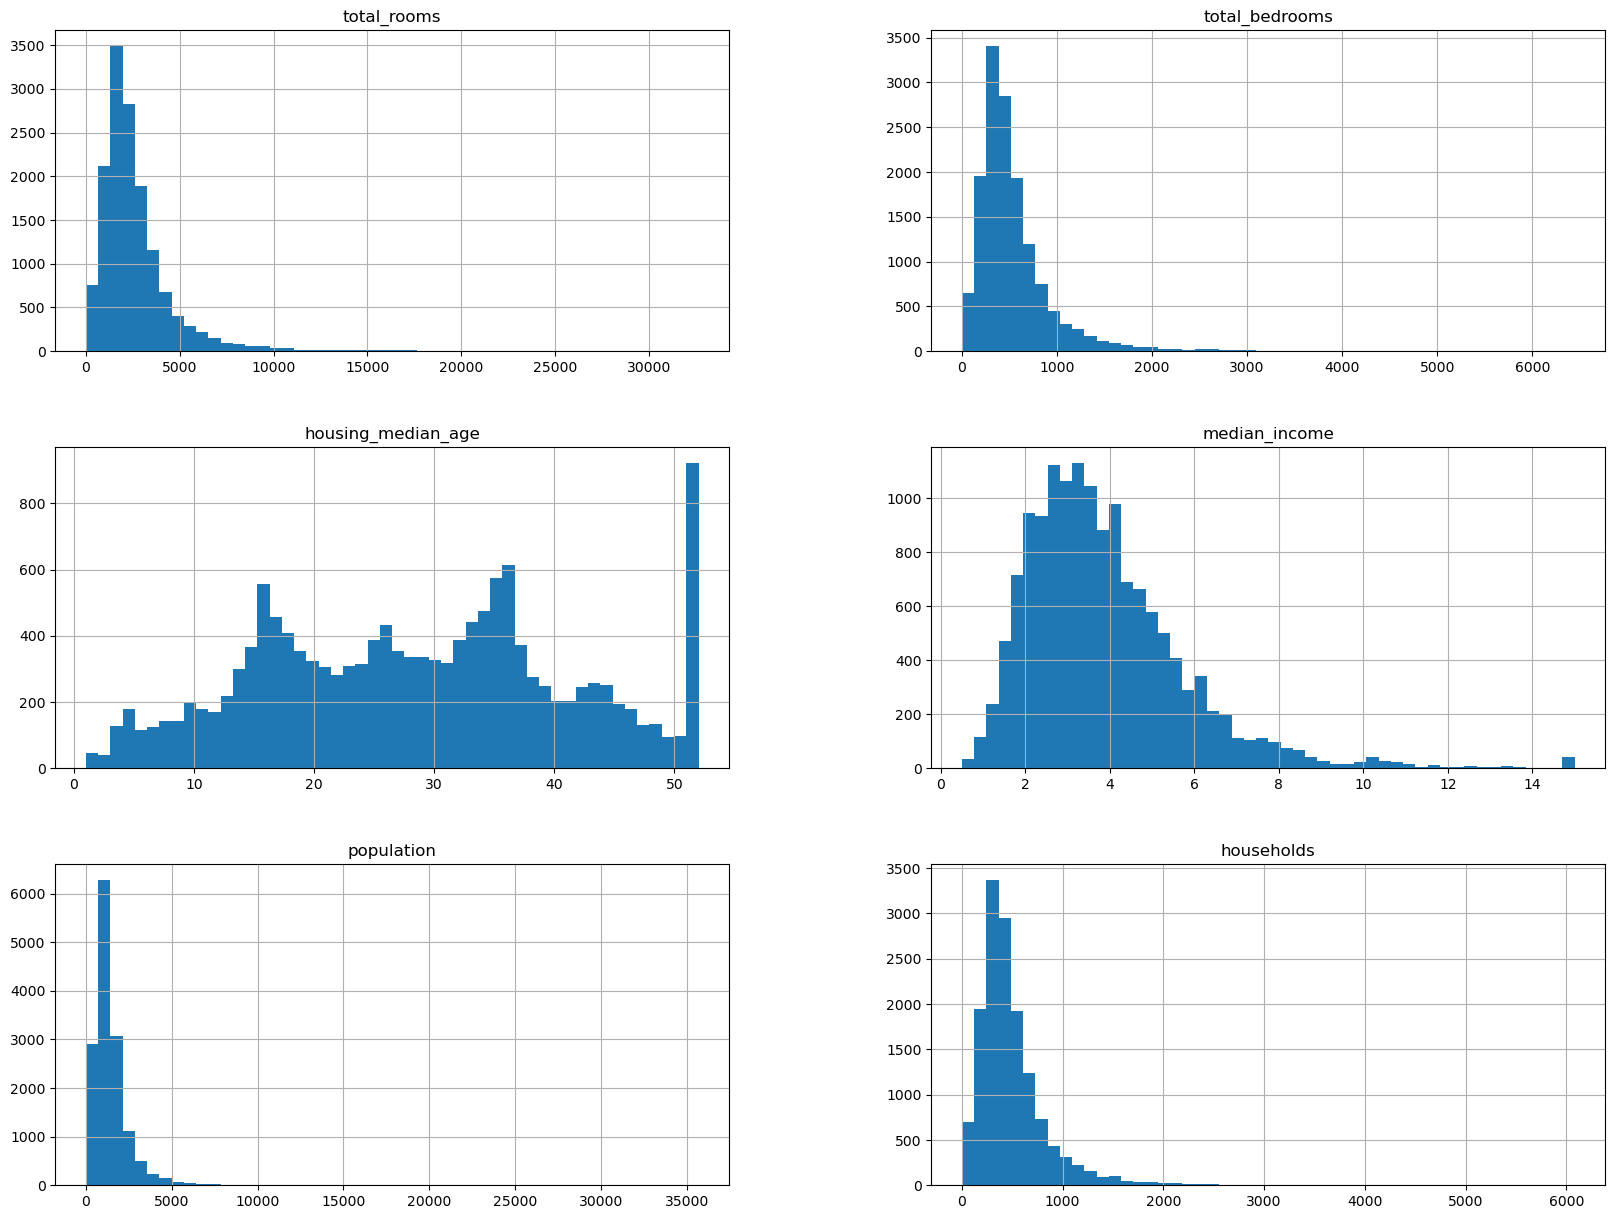

In [11]:
x_train.hist(bins=50, figsize=(20,15))

<Axes: >

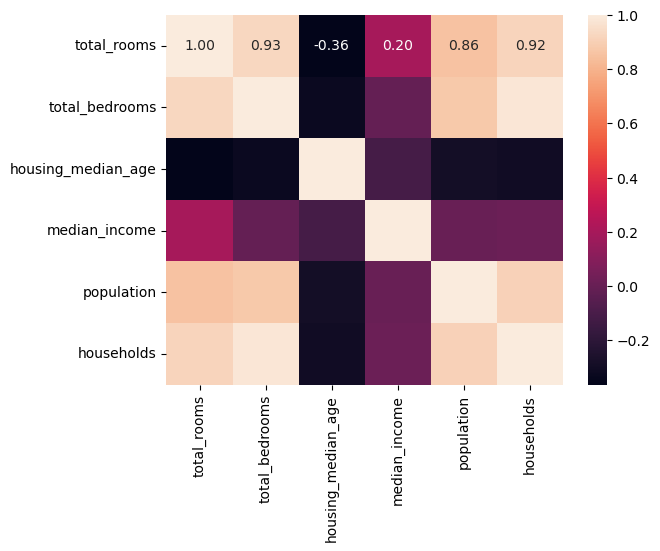

In [12]:
sns.heatmap(x_train.corr(), annot=True, fmt=".2f")

In [13]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.fit_transform(x_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.fit_transform(y_test)


In [22]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

def model_evaluation(model):

    if(model == 'linear'): model = LinearRegression()
    if(model == 'svr'): model = SVR(kernel='rbf', C=5, epsilon=0.1, gamma='auto')
    
    model.fit(x_train_scaled, y_train_scaled)
    y_pred = model.predict(x_test_scaled)
    acc = round(model.score(x_test_scaled, y_test_scaled), 2)
    print('Accuracy:', format(acc))
    mse = mean_squared_error(y_test_scaled, y_pred)
    print('MSE:', format(mse))
    rmse = np.sqrt(mse)
    print('RMSE:', format(rmse))


In [23]:
model_evaluation('linear')

Accuracy: 0.57
MSE: 0.43428770178778425
RMSE: 0.6590050847966078


In [24]:
model_evaluation('svr')

/home/nokkok/anaconda3/envs/introMl/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.68
MSE: 0.32146056262028666
RMSE: 0.5669749223910054
